In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import imageio.v2 as io

In [2]:
from tensorflow.keras.layers import Conv2D, Input, Concatenate, Activation, MaxPool2D, UpSampling2D, GroupNormalization, \
                                    Add, Multiply
from tensorflow.keras.models import Model


## Definitons:

In [3]:
def conv(x, filters:int=8, activation:str="swish"):
    for i in range(2):
        x = Conv2D(filters, (3,3), padding='same')(x)
        x = GroupNormalization(groups=-1)(x) # InstanceNorm
        x = Activation(activation)(x)
    return x

In [4]:
def unet(filters=8, layers=4, input_shape=(224,224,1), activation='swish'):
    to_concat = []
    
    model_in = Input(input_shape)
    x = model_in
    
    # Encoder
    for i in range(layers):
        x = conv(x, filters*2**i, activation)
        to_concat.append(x)
        x = MaxPool2D()(x)
    
    # Latent
    x = Conv2D(filters*2**layers, (3,3), padding='same')(x)
    x = GroupNormalization(groups=-1)(x)  # InstanceNorm
    x = Activation(activation)(x)
    
    # Decoder
    for i in range(layers):
        x = UpSampling2D()(x)
        x = Concatenate()([x, to_concat.pop()])
        x = conv(x, filters*2**(layers-i-1), activation)
    
    x = Conv2D(1, (1,1), padding='same')(x)
    model_out = Activation("sigmoid")(x)
    
    return Model(model_in, model_out)

In [5]:
def nestedUnet(nests=4, filters=1, forward_input=True, operation="multiply", input_shape=(256, 256, 1)):
    x = Input(input_shape)
    m0 = unet(filters, input_shape=input_shape)(x)
    
    if nests > 1:
        tmp = m0
        
        for i in range(nests-1):
            if forward_input:
                if operation == 'add':
                    tmp = Add()([x, tmp])
                    
                elif operation == 'multiply':
                    tmp = Multiply()([x, tmp])
                    
                else:
                    tmp = Concatenate(axis=3)([x, tmp])
                
            tmp = unet(filters, input_shape=tmp.shape[1:])(tmp)

        return Model(x, tmp)        
        
    else:
        return Model(x, m0)

In [17]:
def readDataSet(folderPath: str, numIms: int , isTraining: bool = False, randomize: bool = True, output: list = [])->list:
    '''
    Reads the dataset from the given folder path and returns a list of images and masks
    returns [images, masks] if isTraining is True
    returns [images] if isTraining is False
    '''

    imgPaths = [folderPath + str(i) + ".png" for i in range(numIms)]
    if isTraining:
        maskPaths = [folderPath + str(i) + "_seg.png" for i in range(numIms)]
        masks = []
        for i in range(numIms):
            mask = io.imread(maskPaths[i])
            if np.max(mask) != 0:  # To remove the black images
                if np.max(mask) > 10:
                    mask = mask / 255.0

                img = io.imread(imgPaths[i]) / 255.0

                output.append(np.array(tf.expand_dims(img, -1)))
                masks.append(np.array(tf.expand_dims(mask, -1)))
        if randomize:
            # Randomizing
            nSamples = len(output)
            np.random.seed(42)
            indices = np.arange(nSamples)
            np.random.shuffle(indices)  # Shuffling indices directly

            output = [output[i] for i in indices]
            masks = [masks[i] for i in indices]
        return [output, masks]
    
    else:
        for i in range(len(imgPaths)):
            img = io.imread(output[i]) / 255.0
            output.append(np.array(tf.expand_dims(img, -1)))
        return output

## Training:

In [6]:
TRAINING_PATH = "./training224x224/"
image_width = 224
image_height = 224
NUM_NESTS = 4 # 1, 2, 4, 8, 16
NUM_FILTERS = 8 # 16
OPERATION = "multiply" # "add", "multiply", "concatenate"
   
N = 22 # arbitrary number of samples

train_imgs = [TRAINING_PATH + str(i) + ".png" for i in range(N)]
train_segs = [TRAINING_PATH + str(i) + "_seg.png" for i in range(N)]

imgs = []
segs = []

for i in range(N):
    seg = io.imread(train_segs[i])
    if np.max(seg) != 0:  # To remove the black images
        if np.max(seg) > 10:
            seg = seg / 255.0

        img = io.imread(train_imgs[i]) / 255.0

        imgs.append(np.array(tf.expand_dims(img, -1))) # imgs.append(np.expand_dims(img, axis=2))
        segs.append(np.array(tf.expand_dims(seg, -1))) # segs.append(np.expand_dims(seg, axis=2))

# Randomizing
nSamples = len(imgs)
np.random.seed(42)
indices = np.arange(nSamples)
np.random.shuffle(indices)  # Shuffling indices directly

imgs = [imgs[i] for i in indices]
segs = [segs[i] for i in indices]


plt.imshow(imgs[0], cmap = 'gray')


In [8]:
nestedModel = nestedUnet(nests=NUM_NESTS, filters=NUM_FILTERS, operation=OPERATION, input_shape=(image_width, image_height, 1))

nestedModel.summary()
nestedModel.compile("adam", "mse")

# Training
history = nestedModel.fit(np.array(imgs), np.array(segs), epochs=10, batch_size=4)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 model (Functional)          (None, 224, 224, 1)          344625    ['input_1[0][0]']             
                                                                                                  
 multiply (Multiply)         (None, 224, 224, 1)          0         ['input_1[0][0]',             
                                                                     'model[0][0]']               
                                                                                                  
 model_1 (Functional)        (None, 224, 224, 1)          344625    ['multiply[0][0]']      

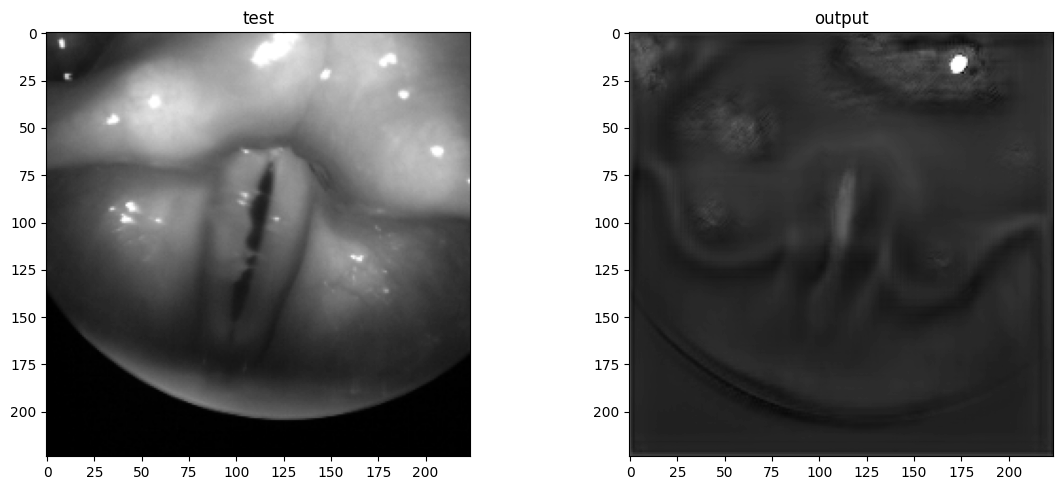

In [14]:
tests = []
test_imgs = [TRAINING_PATH + str(i) + ".png" for i in range(N+1,N+10)]
for i in range(len(test_imgs)):
    img = io.imread(test_imgs[i]) / 255.0
    tests.append(np.array(tf.expand_dims(img, -1)))
    
# predicting:
pred = nestedModel.predict(np.array(tests))
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(tests[0], cmap='gray'); plt.title('test')
plt.subplot(1,2,2); plt.imshow(pred[0], cmap='gray'); plt.title('output')
plt.tight_layout() 

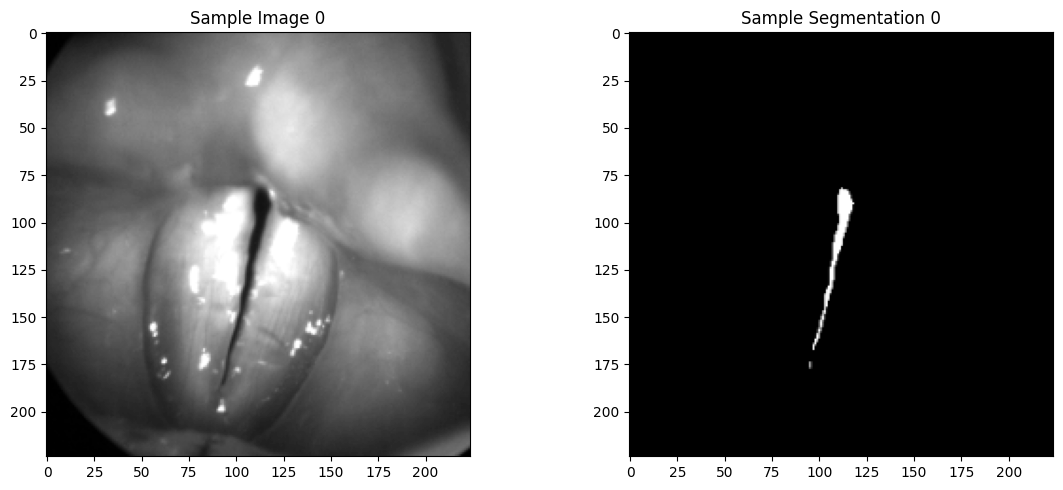

In [18]:
TRAINING_PATH = "./training224x224/"
image_width = 224
image_height = 224
numNests = [1, 2, 4, 8, 16]
numFilters = [8, 16] 
operations = ["add", "multiply", "concatenate"]
N = 22 # arbitrary number of samples

imgs, segs = readDataSet(folderPath = TRAINING_PATH, numIms = N , isTraining = True, randomize = True)

# show a random sample k 
k = 0
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(imgs[0], cmap='gray'); plt.title(f"Sample Image {k}")
plt.subplot(1,2,2); plt.imshow(segs[0], cmap='gray'); plt.title(f"Sample Segmentation {k}")
plt.tight_layout() 

In [ ]:
for currentNumNests in numNests:
    for currentNumFilters in numFilters:
        for currentOperation in operations:
            
            nestedModel = nestedUnet(nests=currentNumNests, filters=currentNumFilters, operation=currentOperation, input_shape=(image_width, image_height, 1))
            nestedModel.compile("adam", "mse")

            # Training
            history = nestedModel.fit(np.array(imgs), np.array(segs), epochs=10, batch_size=4)

            # Checkpoints
            nestedModel.save(f"nestedUnet_{currentNumNests}_{currentNumFilters}_{currentOperation}.h5")